In [122]:
import os
import pandas as pd
import numpy as np
import joblib
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Lectura y preprocesamiento

In [123]:
# Carga el dataset
df_og = pd.read_csv('loan/loan.csv')

 # Mapea el target
status_map = {
     "Fully Paid": 0,
     "Charged Off": 1,
     "Late (31-120 days)": 1,
     "Default": 1,
     "Does not meet the credit policy. Status:Fully Paid": 0,
     "Does not meet the credit policy. Status:Charged Off": 1
 }
df_og['target'] = df_og['loan_status'].map(status_map)

C:\Users\User\AppData\Local\Temp\ipykernel_17256\3215090333.py:2: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_og = pd.read_csv('loan/loan.csv')


In [124]:
import pandas as pd
  # o como sea que obtengas tu DataFrame
df = df_og[df_og['target'].notna()].copy()

In [125]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,target
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Explora el balance de clases

In [126]:
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))

target
0.0    209711
1.0     58819
Name: count, dtype: int64
target
0.0    0.780959
1.0    0.219041
Name: proportion, dtype: float64


## Preprocesamiento

In [127]:
df_varibales_categoricas = df.select_dtypes(include=['object']).astype("category")

In [128]:
null_counts = df_varibales_categoricas.isna().sum()
print(null_counts[null_counts > 15])

emp_title                     14958
emp_length                    10721
desc                         176559
title                            16
earliest_cr_line                 29
last_pymnt_d                    668
next_pymnt_d                 252971
last_credit_pull_d               24
verification_status_joint    268527
dtype: int64


In [129]:
df["earliest_cr_line"]

0         Jan-1985
1         Apr-1999
2         Nov-2001
3         Feb-1996
5         Nov-2004
            ...   
887351    Aug-1990
887364    Nov-1975
887366    Feb-2011
887369    Sep-2002
887371    Jun-2002
Name: earliest_cr_line, Length: 268530, dtype: object

In [130]:
df["last_credit_pull_d"]

0         Jan-2016
1         Sep-2013
2         Jan-2016
3         Jan-2015
5         Sep-2015
            ...   
887351    Jan-2016
887364    Jun-2015
887366    Dec-2015
887369    Nov-2015
887371    Jan-2016
Name: last_credit_pull_d, Length: 268530, dtype: object

In [131]:
df["last_pymnt_d"]

0         Jan-2015
1         Apr-2013
2         Jun-2014
3         Jan-2015
5         Jan-2015
            ...   
887351    Aug-2015
887364    Jul-2015
887366    Dec-2015
887369    Jun-2015
887371    Aug-2015
Name: last_pymnt_d, Length: 268530, dtype: object

se eliminan todas estas columnas puesto que tienen más de 10 mil nulos y las otras 3 no son significativas y agregarian mucha complejidad al ser fechas

In [132]:
# Remove columns with many null values and date columns
columns_to_remove = ['earliest_cr_line', 'last_credit_pull_d', 'last_pymnt_d', "emp_length", "next_pymnt_d", "verification_status_joint", "desc", "emp_title", "title"]
df = df.drop(columns=columns_to_remove, errors='ignore')

In [133]:
df_varibales_categoricas = df.select_dtypes(include=['object']).astype("category")

In [134]:
df_varibales_categoricas.head()

,term,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,initial_list_status,application_type
0,36 months,B,B2,RENT,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,860xx,AZ,f,INDIVIDUAL
1,60 months,C,C4,RENT,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,309xx,GA,f,INDIVIDUAL
2,36 months,C,C5,RENT,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,606xx,IL,f,INDIVIDUAL
3,36 months,C,C1,RENT,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,other,917xx,CA,f,INDIVIDUAL
5,36 months,A,A4,RENT,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,wedding,852xx,AZ,f,INDIVIDUAL


In [135]:
df_varibales_categoricas["application_type"].value_counts()

application_type
INDIVIDUAL    268527
JOINT              3
Name: count, dtype: int64

se elimina porque practicamente todos los valores son iguales, por lo que no tendrá significancia para el modelo

In [136]:
df = df.drop(columns=["application_type"], errors='ignore')

A el resto de columnas categoricas se les aplica one hot encoder para incluirlas en el analisis de significancia de las variables para el modelo

In [137]:
# Elimina columnas problemáticas
cols_to_drop = ['id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'loan_status', 'emp_title']
df = df.drop(columns=cols_to_drop, errors='ignore')

In [138]:
# Get categorical columns from df (excluding certain columns we don't want to encode)
df_varibales_categoricas = df.select_dtypes(include=['object'])
categorical_columns = df_varibales_categoricas.columns
categorical_columns = [col for col in categorical_columns]

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [139]:
df_varibales_categoricas 

,term,grade,sub_grade,home_ownership,verification_status,issue_d,pymnt_plan,purpose,addr_state,initial_list_status
0,36 months,B,B2,RENT,Verified,Dec-2011,n,credit_card,AZ,f
1,60 months,C,C4,RENT,Source Verified,Dec-2011,n,car,GA,f
2,36 months,C,C5,RENT,Not Verified,Dec-2011,n,small_business,IL,f
3,36 months,C,C1,RENT,Source Verified,Dec-2011,n,other,CA,f
5,36 months,A,A4,RENT,Source Verified,Dec-2011,n,wedding,AZ,f
...,...,...,...,...,...,...,...,...,...,...
887351,36 months,D,D2,MORTGAGE,Verified,Jan-2015,n,medical,CO,f
887364,36 months,A,A1,RENT,Not Verified,Jan-2015,n,debt_consolidation,FL,w
887366,36 months,D,D3,RENT,Source Verified,Jan-2015,n,debt_consolidation,FL,f
887369,36 months,B,B1,MORTGAGE,Verified,Jan-2015,n,car,CA,f


In [140]:
df_encoded.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,5000.0,5000.0,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,...,False,False,False,False,False,False,False,False,False,False
1,2500.0,2500.0,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,...,False,False,False,False,False,False,False,False,False,False
2,2400.0,2400.0,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,...,False,False,False,False,False,False,False,False,False,False
3,10000.0,10000.0,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.0,...,False,False,False,False,False,False,False,False,False,False
5,5000.0,5000.0,5000.0,7.90,156.46,36000.0,11.20,0.0,3.0,NaN,...,False,False,False,False,False,False,False,False,False,False


## Imputacion de nulos

In [141]:
# Imputa nulos
df = df.fillna(df.median(numeric_only=True))

In [142]:
# Imputa nulos
df_encoded = df_encoded.fillna(df_encoded.median(numeric_only=True))

# Analisis de las variables más significativas

In [143]:
X = df_encoded.drop(columns=['target'], errors='ignore')
y = df['target']

## Metodo kbest

In [144]:
# SelectKBest
selector = SelectKBest(f_classif, k=7)
selector.fit(X, y)

# Obtener scores
scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
})
scores = scores.sort_values('Score', ascending=False)

print("Importancia de características:")
print(scores)

Importancia de características:
              Feature         Score
20    total_rec_prncp  83367.562104
25    last_pymnt_amnt  54935.222040
23         recoveries  48290.312606
18        total_pymnt  46675.895755
19    total_pymnt_inv  45848.611281
..                ...           ...
161  issue_d_Mar-2013      0.011983
224     addr_state_IA      0.010454
164  issue_d_May-2008      0.001830
235     addr_state_MN      0.001272
28        policy_code           NaN

[264 rows x 2 columns]


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [145]:
scores.head(10)

,Feature,Score
20,total_rec_prncp,83367.562104
25,last_pymnt_amnt,54935.222040
23,recoveries,48290.312606
18,total_pymnt,46675.895755
19,total_pymnt_inv,45848.611281
16,out_prncp,37543.371479
17,out_prncp_inv,37542.785395
24,collection_recovery_fee,20652.987243
3,int_rate,18640.769072
49,term_ 60 months,7765.671379


In [146]:
columnas_seleccionadas = selector.get_support()
nombres_columnas = X.columns[columnas_seleccionadas]
X = X[nombres_columnas]
X.head()

,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,last_pymnt_amnt
0,0.0,0.0,5861.071414,5831.78,5000.00,0.00,171.62
1,0.0,0.0,1008.710000,1008.71,456.46,117.08,119.66
2,0.0,0.0,3003.653644,3003.65,2400.00,0.00,649.91
3,0.0,0.0,12226.302212,12226.30,10000.00,0.00,357.48
5,0.0,0.0,5631.377753,5631.38,5000.00,0.00,161.03


In [147]:
print(df_encoded.groupby('target')[nombres_columnas].count())

        out_prncp  out_prncp_inv  total_pymnt  total_pymnt_inv  \
target                                                           
0.0        209711         209711       209711           209711   
1.0         58819          58819        58819            58819   

        total_rec_prncp  recoveries  last_pymnt_amnt  
target                                                
0.0              209711      209711           209711  
1.0               58819       58819            58819  


lo recomendado es quedarnos con las 7 primeras variables, puesto que a partir de la octava cae considereablemente el score (significancia de la variable), por lo cual, a partir de esta no serian muy explicativas.

## Usar Variables previas al credito

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Importancia de características (solo previas al crédito):
            Feature         Score
3          int_rate  18640.769072
22  term_ 60 months   7765.671379
6               dti   4885.278616
26          grade_E   4058.702753
23          grade_B   3118.862434
25          grade_D   2757.693015
14       revol_util   2717.368457
27          grade_F   2668.659097
1       funded_amnt   1371.005222
0         loan_amnt   1360.737717


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7719 - auc_6: 0.6316 - loss: 0.5181 - val_accuracy: 0.7814 - val_auc_6: 0.6919 - val_loss: 0.4857
Epoch 2/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7816 - auc_6: 0.6739 - loss: 0.4934 - val_accuracy: 0.7814 - val_auc_6: 0.6925 - val_loss: 0.4851
Epoch 3/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7802 - auc_6: 0.6807 - loss: 0.4918 - val_accuracy: 0.7814 - val_auc_6: 0.6927 - val_loss: 0.4851
Epoch 4/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7824 - auc_6: 0.6814 - loss: 0.4888 - val_accuracy: 0.7814 - val_auc_6: 0.6930 - val_loss: 0.4856
Epoch 5/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7817 - auc_6: 0.6809 - loss: 0.4902 - val_accuracy: 0.7813 - val_auc_6: 0.6932 - val_loss: 0.4850
Epoch 6/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7807 - auc_6: 0.6831 - loss: 0.4903 - val_accuracy: 0.7820 - val_auc_6: 0.6937 - val_loss: 0.4847
Epoch 7/50
672/6

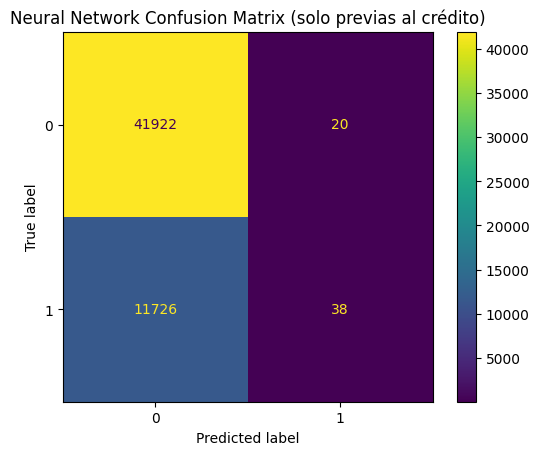

In [148]:
# --- NUEVO FLUJO: Solo variables previas al crédito y red neuronal ---

# 1. Selección de variables previas al crédito
# Lista extendida de variables previas al crédito
vars_credito = [
    # Previas al crédito
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state',
    'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'application_type', 'open_acc',
    'pub_rec', 'revol_bal', 'initial_list_status',
    # Comportamiento durante el crédito (NUEVAS)
    'last_pymnt_amnt', 'last_pymnt_d', 'total_rec_prncp', 'total_rec_int',
    'out_prncp', 'out_prncp_inv', 'recoveries', 'total_pymnt', 'total_pymnt_inv',
    'mths_since_last_delinq', 'mths_since_last_record'
]

# Filtra el DataFrame original para quedarte solo con estas variables + target
_df_preloan = df_og[[col for col in pre_loan_vars if col in df_og.columns] + ['loan_status']].copy()
_df_preloan['target'] = _df_preloan['loan_status'].map(status_map)
_df_preloan = _df_preloan[_df_preloan['target'].notna()].copy()

# 2. Preprocesamiento
# Elimina columnas con muchos nulos si es necesario
_df_preloan = _df_preloan.drop(columns=['emp_length'], errors='ignore')

# One-hot encoding para variables categóricas
_categorical_columns = _df_preloan.select_dtypes(include=['object']).columns.tolist()
_categorical_columns = [col for col in _categorical_columns if col not in ['loan_status']]
_df_preloan_encoded = pd.get_dummies(_df_preloan, columns=_categorical_columns, drop_first=True)

# Imputa nulos
_df_preloan_encoded = _df_preloan_encoded.fillna(_df_preloan_encoded.median(numeric_only=True))

# 3. Selección de variables más importantes
from sklearn.feature_selection import SelectKBest, f_classif
X_preloan = _df_preloan_encoded.drop(columns=['target', 'loan_status'], errors='ignore')
y_preloan = _df_preloan_encoded['target']

# Selecciona las 7 variables más importantes
_selector = SelectKBest(f_classif, k=7)
_selector.fit(X_preloan, y_preloan)
_scores = pd.DataFrame({'Feature': X_preloan.columns, 'Score': _selector.scores_}).sort_values('Score', ascending=False)
print("Importancia de características (solo previas al crédito):")
print(_scores.head(10))

_selected_columns = X_preloan.columns[_selector.get_support()]
X_selected_preloan = X_preloan[_selected_columns]

# 4. Split y escalado
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X_train_preloan, X_test_preloan, y_train_preloan, y_test_preloan = train_test_split(
    X_selected_preloan, y_preloan, test_size=0.2, random_state=42, stratify=y_preloan)
scaler_preloan = preprocessing.StandardScaler()
X_train_preloan_scaled = scaler_preloan.fit_transform(X_train_preloan)
X_test_preloan_scaled = scaler_preloan.transform(X_test_preloan)

# 5. Red neuronal
from tensorflow import keras
from tensorflow.keras import layers
model_preloan = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_preloan_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])
model_preloan.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC()]
)
early_stopping_preloan = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history_preloan = model_preloan.fit(
    X_train_preloan_scaled, y_train_preloan,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping_preloan],
    verbose=1
)

# 6. Evaluación
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred_prob_preloan = model_preloan.predict(X_test_preloan_scaled)
y_pred_classes_preloan = (y_pred_prob_preloan > 0.5).astype(int)
print("AUC Score (solo previas al crédito):", roc_auc_score(y_test_preloan, y_pred_prob_preloan))
print(classification_report(y_test_preloan, y_pred_classes_preloan))
cm_preloan = confusion_matrix(y_test_preloan, y_pred_classes_preloan)
disp_preloan = ConfusionMatrixDisplay(confusion_matrix=cm_preloan)
disp_preloan.plot()
plt.title('Neural Network Confusion Matrix (solo previas al crédito)')
plt.show()

# --- FIN NUEVO FLUJO ---

no funciona solo con datos antes de que comience el credito lastimosamente por que da muchos falsos positivos en lo que respecta a gente que el modelo dice que si cumplen pero alfinal no van a cumplir nada.

## Variables antes y mientras se da el credito usando un modelo de riesgo dinamico

### 1. Selección de variables

In [149]:
# Variables previas al crédito y de comportamiento
vars_credito = [
    # Previas al crédito
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state',
    'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'application_type', 'open_acc',
    'pub_rec', 'revol_bal', 'initial_list_status',
    # Comportamiento durante el crédito
    'last_pymnt_amnt', 'last_pymnt_d', 'total_rec_prncp', 'total_rec_int',
    'out_prncp', 'out_prncp_inv', 'recoveries', 'total_pymnt', 'total_pymnt_inv',
    'mths_since_last_delinq', 'mths_since_last_record'
]

### 2. Filtrado del DataFrame

In [150]:
# Filtra el DataFrame original para quedarte solo con estas variables + target
df_modelo = df_og[[col for col in vars_credito if col in df_og.columns] + ['loan_status']].copy()

### 3. Ingeniería de variables adicionales

In [152]:
# Porcentaje del principal pagado
if 'total_rec_prncp' in df_modelo.columns and 'loan_amnt' in df_modelo.columns:
    df_modelo['pct_principal_paid'] = df_modelo['total_rec_prncp'] / df_modelo['loan_amnt']

# Porcentaje del plazo pagado (si tienes las fechas)
if 'issue_d' in df_og.columns and 'last_pymnt_d' in df_og.columns and 'term' in df_modelo.columns:
    df_modelo['issue_d'] = pd.to_datetime(df_og['issue_d'], errors='coerce')
    df_modelo['last_pymnt_d'] = pd.to_datetime(df_og['last_pymnt_d'], errors='coerce')
    def diff_months(end_date, start_date):
        return (end_date.dt.year - start_date.dt.year) * 12 + (end_date.dt.month - start_date.dt.month)
    df_modelo['meses_transcurridos'] = diff_months(df_modelo['last_pymnt_d'], df_modelo['issue_d'])
    df_modelo['meses_transcurridos'] = df_modelo['meses_transcurridos'].clip(lower=0)
    df_modelo['term_meses'] = df_modelo['term'].str.extract('(\d+)').astype(float)
    df_modelo['pct_term_paid'] = df_modelo['meses_transcurridos'] / df_modelo['term_meses']

C:\Users\User\AppData\Local\Temp\ipykernel_17256\4044268522.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_modelo['issue_d'] = pd.to_datetime(df_og['issue_d'], errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_17256\4044268522.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_modelo['last_pymnt_d'] = pd.to_datetime(df_og['last_pymnt_d'], errors='coerce')


### 4. Variable objetivo

In [153]:
status_map = {
    "Fully Paid": 0,
    "Charged Off": 1,
    "Late (31-120 days)": 1,
    "Default": 1,
    "Does not meet the credit policy. Status:Fully Paid": 0,
    "Does not meet the credit policy. Status:Charged Off": 1
}
df_modelo['target'] = df_modelo['loan_status'].map(status_map)
df_modelo = df_modelo[df_modelo['target'].notna()].copy()

### 5. Preprocesamiento (one-hot, nulos)

In [154]:
categorical_vars = df_modelo.select_dtypes(include=['object']).columns.tolist()
categorical_vars = [col for col in categorical_vars if col not in ['loan_status']]
df_modelo = pd.get_dummies(df_modelo, columns=categorical_vars, drop_first=True)
df_modelo = df_modelo.fillna(df_modelo.median(numeric_only=True))

### 6. Selección de variables más importantes

In [156]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# X e y para el modelo
X = df_modelo.drop(columns=['loan_status', 'target'], errors='ignore')
y = df_modelo['target']

# Elimina columnas de tipo fecha (datetime) antes de SelectKBest y modelado
X = X.select_dtypes(exclude=['datetime64[ns]', 'datetime64[ns, UTC]'])

# Selección de variables más importantes
selector = SelectKBest(f_classif, k=10)  # Puedes ajustar k según prefieras
selector.fit(X, y)
scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_}).sort_values('Score', ascending=False)
print("Importancia de características (previas y comportamiento):")
print(scores.head(15))

selected_columns = X.columns[selector.get_support()]
X_selected = X[selected_columns]

Importancia de características (previas y comportamiento):
                Feature         Score
21   pct_principal_paid  2.404721e+06
12      total_rec_prncp  8.336756e+04
11      last_pymnt_amnt  5.493522e+04
16           recoveries  4.829031e+04
17          total_pymnt  4.667590e+04
18      total_pymnt_inv  4.584861e+04
14            out_prncp  3.754337e+04
15        out_prncp_inv  3.754279e+04
1              int_rate  1.864077e+04
24        pct_term_paid  1.175500e+04
22  meses_transcurridos  7.881914e+03
25      term_ 60 months  7.765671e+03
23           term_meses  7.765671e+03
4                   dti  4.885279e+03
29              grade_E  4.058703e+03


### 7. Split y escalado

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 8. Red neuronal

In [158]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC()]
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


672/672 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9445 - auc_7: 0.9684 - loss: 0.1634 - val_accuracy: 0.9942 - val_auc_7: 0.9991 - val_loss: 0.0182
Epoch 2/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9941 - auc_7: 0.9982 - loss: 0.0220 - val_accuracy: 0.9960 - val_auc_7: 0.9992 - val_loss: 0.0125
Epoch 3/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9961 - auc_7: 0.9986 - loss: 0.0154 - val_accuracy: 0.9980 - val_auc_7: 0.9995 - val_loss: 0.0075
Epoch 4/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9973 - auc_7: 0.9990 - loss: 0.0112 - val_accuracy: 0.9984 - val_auc_7: 0.9995 - val_loss: 0.0058
Epoch 5/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9977 - auc_7: 0.9991 - loss: 0.0093 - val_accuracy: 0.9986 - val_auc_7: 0.9996 - val_loss: 0.0051
Epoch 6/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9980 - auc_7: 0.9993 - loss: 0.0083 - val_accuracy: 0.9986 - val_auc_7: 0.9996 - val_loss: 0.0048
Epoch 7/50
672/672 ━━━━━━━━

### 9. Evaluación

1679/1679 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step
AUC Score (previas y comportamiento): 0.9997672969671966
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41942
         1.0       1.00      1.00      1.00     11764

    accuracy                           1.00     53706
   macro avg       1.00      1.00      1.00     53706
weighted avg       1.00      1.00      1.00     53706



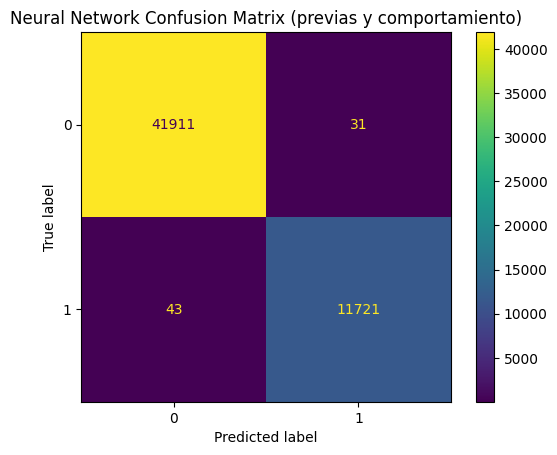

In [159]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = (y_pred_prob > 0.5).astype(int)
print("AUC Score (previas y comportamiento):", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred_classes))
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Neural Network Confusion Matrix (previas y comportamiento)')
plt.show()